In [ ]:
import pandas as pd
df = pd.read_excel("BTC.xlsx")
df.columns = df.columns.str.strip().str.lower()

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)

df = df.dropna()
df['volatility'] = (df['high'] - df['low']) / df['close']
df['volume_prev'] = df['volume'].shift(1)
df['volatility_prev'] = df['volatility'].shift(1)
df['volume_delta'] = df['volume'] - df['volume_prev']
df['volatility_delta'] = df['volatility'] - df['volatility_prev']


df.head()


,date,open,high,low,close,adj close,volume,volatility,volume_prev,volatility_prev,volume_delta,volatility_delta,return,return_delta
2,2020-12-08,19191.53,19283.48,18269.95,18321.14,18321.14,31692288756,0.055320,2.689636e+10,0.025047,4.795931e+09,0.030273,-0.045358,-0.037423
3,2020-12-09,18320.88,18626.29,17935.55,18553.92,18553.92,34420373071,0.037229,3.169229e+10,0.055320,2.728084e+09,-0.018091,0.012706,0.058063
4,2020-12-10,18553.30,18553.30,17957.06,18264.99,18264.99,25547132265,0.032644,3.442037e+10,0.037229,-8.873241e+09,-0.004585,-0.015572,-0.028278
5,2020-12-11,18263.93,18268.45,17619.53,18058.90,18058.90,27919640985,0.035934,2.554713e+10,0.032644,2.372509e+09,0.003290,-0.011283,0.004289
6,2020-12-12,18051.32,18919.55,18046.04,18803.66,18803.66,21752580802,0.046454,2.791964e+10,0.035934,-6.167060e+09,0.010521,0.041241,0.052524


In [ ]:
# Prepare feature (X) and target (y)
volume_changes = df['volume_delta'].values.reshape(-1, 1)
volatility_changes = df['volatility_delta'].values


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linear_model = LinearRegression()
linear_model.fit(volume_changes, volatility_changes)

linear_predictions = linear_model.predict(volume_changes)

linear_r2 = r2_score(volatility_changes, linear_predictions)

slope = linear_model.coef_[0]
intercept = linear_model.intercept_

print("----- CRYPTO BTC: LINEAR MODEL -----")
print(f"R² Score: {linear_r2:.4f} ({linear_r2*100:.2f}%)")
print(f"Equation: Δσ = {slope:.6e} × ΔV + {intercept:.6e}")


----- CRYPTO BTC: LINEAR MODEL -----
R² Score: 0.2763 (27.63%)
Equation: Δσ = 9.229634e-13 × ΔV + -1.582642e-05


In [5]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(volume_changes)

poly_model = LinearRegression()
poly_model.fit(X_poly, volatility_changes)

poly_predictions = poly_model.predict(X_poly)

r2_poly = r2_score(volatility_changes, poly_predictions)

print("\n----- CRYPTO BTC: POLYNOMIAL MODEL (Degree 2) -----")
print(f"R² Score: {r2_poly:.4f} ({r2_poly*100:.2f}%)")



----- CRYPTO BTC: POLYNOMIAL MODEL (Degree 2) -----
R² Score: 0.2763 (27.63%)


In [6]:
print("\n----- CRYPTO MODEL COMPARISON -----")
print(f"Linear R²:     {linear_r2:.4f}")
print(f"Polynomial R²: {r2_poly:.4f}")

improvement = r2_poly - linear_r2

print(f"\nImprovement: {improvement:.4f} ({improvement*100:.2f}%)")

if r2_poly > linear_r2:
    print(f"Polynomial model is better by {improvement*100:.2f}%")
else:
    print("Linear model is better for crypto.")



----- CRYPTO MODEL COMPARISON -----
Linear R²:     0.2763
Polynomial R²: 0.2763

Improvement: 0.0000 (0.00%)
Polynomial model is better by 0.00%


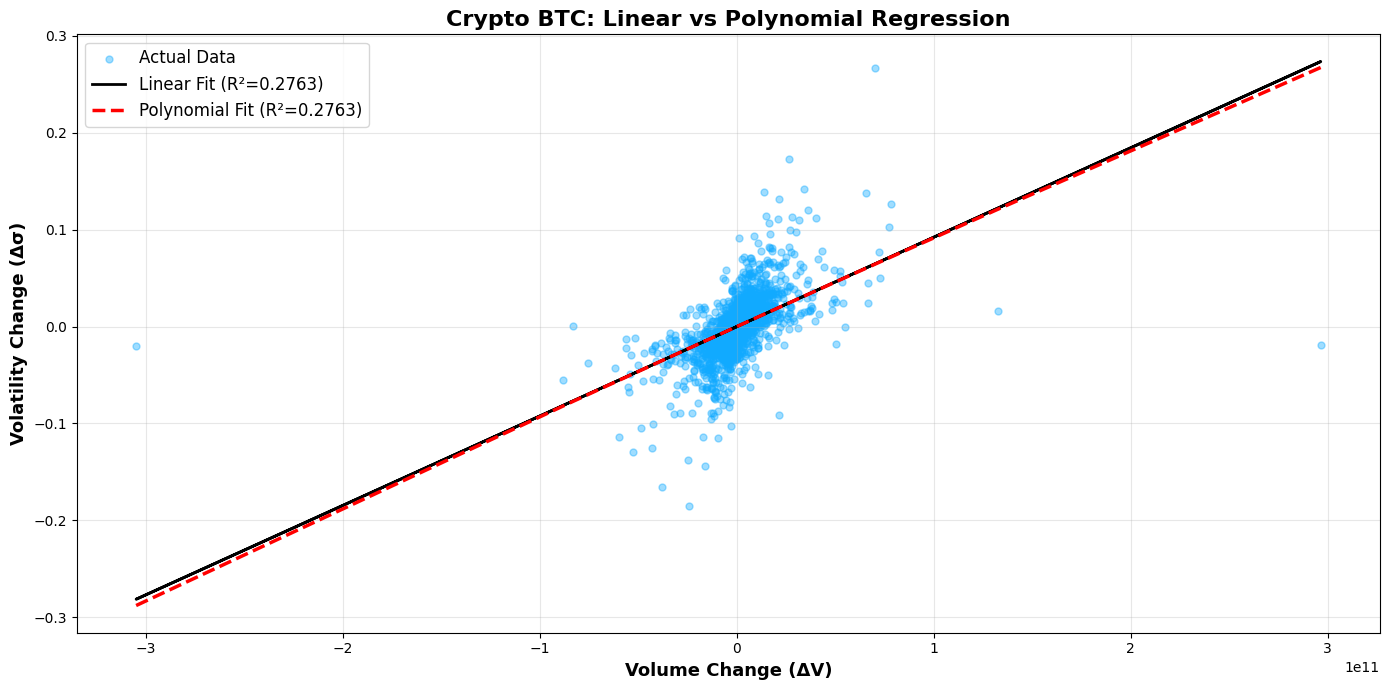

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# Scatter plot
plt.scatter(volume_changes, volatility_changes,
            alpha=0.4, s=25, color='#11aaff',
            label='Actual Data')

# Linear fit
plt.plot(volume_changes, linear_predictions,
         color='black', linewidth=2,
         label=f'Linear Fit (R²={linear_r2:.4f})')

# Sorted polynomial fit
sorted_idx = np.argsort(volume_changes.flatten())
plt.plot(volume_changes[sorted_idx], poly_predictions[sorted_idx],
         color='red', linewidth=2.5, linestyle='--',
         label=f'Polynomial Fit (R²={r2_poly:.4f})')

plt.xlabel("Volume Change (ΔV)", fontsize=13, fontweight="bold")
plt.ylabel("Volatility Change (Δσ)", fontsize=13, fontweight="bold")
plt.title("Crypto BTC: Linear vs Polynomial Regression", fontsize=16, fontweight="bold")

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
